In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from tqdm import tqdm

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import autoguide
import pyro.poutine as poutine

import logging
import anndata as ad
import gc

from utils_data import get_top_eqtls

Download and preprocess data. Output format:

dictionary {snp_celltype_gene : \[ train_x, train_y, validation_x, validation_y, test_x, test_y]}

train_x = [
- homozygous_alternative_onehot_encoded,
- homozygous_reference_onehot_encoded,
- heterozygous_onehot_encoded,
- library_sizes]

train_y = raw counts

In [2]:
data = get_top_eqtls(20, raw=True)

Loading expression data..
Expression data loaded
Getting the raw counts
Getting data for single SNPs


100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


# ZINB model

In [4]:
def model(hom_alt, hom_ref, het, lib_size, expression=None):
    
    # Probability of dropout
    p_hom_alt = pyro.sample('p_hom_alt', dist.Beta(1, 1))
    p_hom_ref = pyro.sample('p_hom_ref', dist.Beta(1, 1))
    p_het = pyro.sample('p_het', dist.Beta(1, 1))
    p = p_hom_alt * hom_alt + p_hom_ref * hom_ref + p_het * het
    
    # Gamma distribution
    alpha_hom_alt = pyro.sample('alpha_hom_alt', dist.LogNormal(1,1))
    beta_hom_alt = pyro.sample('beta_hom_alt', dist.LogNormal(1, 1))
    alpha_hom_ref = pyro.sample('alpha_hom_ref', dist.LogNormal(1,1))
    beta_hom_ref = pyro.sample('beta_hom_ref', dist.LogNormal(1, 1))
    alpha_het = pyro.sample('alpha_het', dist.LogNormal(1,1))
    beta_het = pyro.sample('beta_het', dist.LogNormal(1, 1))
    alpha = alpha_hom_alt*hom_alt + alpha_hom_ref*hom_ref + alpha_het*het
    beta = beta_hom_alt*hom_alt + beta_hom_ref*hom_ref + beta_het*het
    with pyro.plate('weights', p.shape[0]):
        weight = pyro.sample('weight', dist.Gamma(alpha, beta))
    
    with pyro.plate('data', p.shape[0]):
        assignment = pyro.sample('assignment', dist.Bernoulli(probs=p))
        assignment = assignment.reshape(assignment.shape[0], 1).type(torch.int64)

        poisson_lambda = torch.stack([torch.tensor(0.001).repeat(p.shape[0]), 
                                      weight*lib_size]).transpose(0, 1)
        
        return pyro.sample('obs', dist.Poisson(poisson_lambda.gather(1, assignment).flatten()), obs=expression)

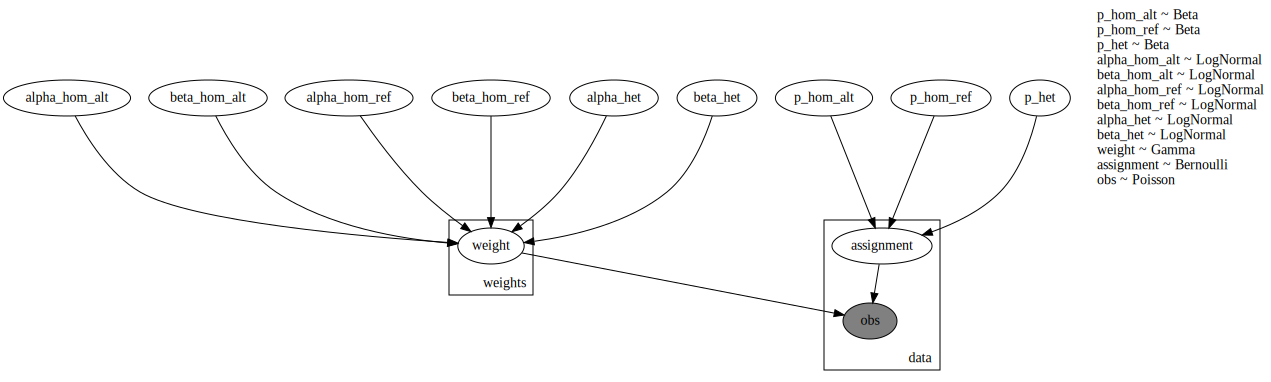

In [7]:
train_x = data['rs10088428_CD4 NC_HMBOX1'][0]
train_y = data['rs10088428_CD4 NC_HMBOX1'][1]

pyro.render_model(model, model_args = (*train_x, train_y),render_params=True, render_distributions=True)

In [8]:
def guide(hom_alt, hom_ref, het, lib_size, expression=None):
    ### Probability of dropout ###
    # Parameters
    p_hom_alt_a = pyro.param('p_hom_alt_a', lambda: torch.tensor(1), constraint=constraints.positive)
    p_hom_alt_b = pyro.param('p_hom_alt_b', lambda: torch.tensor(1), constraint=constraints.positive)
    p_hom_ref_a = pyro.param('p_hom_ref_a', lambda: torch.tensor(1), constraint=constraints.positive)
    p_hom_ref_b = pyro.param('p_hom_ref_b', lambda: torch.tensor(1), constraint=constraints.positive)
    p_het_a = pyro.param('p_het_a', lambda: torch.tensor(1), constraint=constraints.positive)
    p_het_b = pyro.param('p_het_b', lambda: torch.tensor(1), constraint=constraints.positive)
    
    # Probability
    p_hom_alt = pyro.sample('p_hom_alt', dist.Beta(p_hom_alt_a, p_hom_alt_b))
    p_hom_ref = pyro.sample('p_hom_ref', dist.Beta(p_hom_ref_a, p_hom_ref_b))
    p_het = pyro.sample('p_het', dist.Beta(p_het_a, p_het_b))
    
    ### Gamma parameters ###
    # Parameters
    a_alpha_hom_alt = pyro.param('a_alpha_hom_alt', lambda: torch.tensor(1), constraint=constraints.positive)
    a_alpha_hom_ref = pyro.param('a_alpha_hom_ref', lambda: torch.tensor(1), constraint=constraints.positive)
    a_alpha_het = pyro.param('a_alpha_het', lambda: torch.tensor(1), constraint=constraints.positive)
    a_beta_hom_alt = pyro.param('a_beta_hom_alt', lambda: torch.tensor(1), constraint=constraints.positive)
    a_beta_hom_ref = pyro.param('a_beta_hom_ref', lambda: torch.tensor(1), constraint=constraints.positive)
    a_beta_het = pyro.param('a_beta_het', lambda: torch.tensor(1), constraint=constraints.positive)
    
    b_alpha_hom_alt = pyro.param('b_alpha_hom_alt', lambda: torch.tensor(1), constraint=constraints.positive)
    b_alpha_hom_ref = pyro.param('b_alpha_hom_ref', lambda: torch.tensor(1), constraint=constraints.positive)
    b_alpha_het = pyro.param('b_alpha_het', lambda: torch.tensor(1), constraint=constraints.positive)
    b_beta_hom_alt = pyro.param('b_beta_hom_alt', lambda: torch.tensor(1), constraint=constraints.positive)
    b_beta_hom_ref = pyro.param('b_beta_hom_ref', lambda: torch.tensor(1), constraint=constraints.positive)
    b_beta_het = pyro.param('b_beta_het', lambda: torch.tensor(1), constraint=constraints.positive)

    alpha_hom_alt = pyro.sample('alpha_hom_alt', dist.LogNormal(a_alpha_hom_alt, b_alpha_hom_alt))
    beta_hom_alt = pyro.sample('beta_hom_alt', dist.LogNormal(a_beta_hom_alt, b_beta_hom_alt))
    alpha_hom_ref = pyro.sample('alpha_hom_ref', dist.LogNormal(a_alpha_hom_ref, b_alpha_hom_ref))
    beta_hom_ref = pyro.sample('beta_hom_ref', dist.LogNormal(a_beta_hom_ref, b_beta_hom_ref))
    alpha_het = pyro.sample('alpha_het', dist.LogNormal(a_alpha_het, b_alpha_het))
    beta_het = pyro.sample('beta_het', dist.LogNormal(a_beta_het, b_beta_het))
    
    alpha = alpha_hom_alt*hom_alt + alpha_hom_ref * hom_ref + alpha_het * het
    # b_alpha = b_alpha_hom_alt*hom_alt + b_alpha_hom_ref * hom_ref + b_alpha_het * het
    beta = beta_hom_alt*hom_alt + beta_hom_ref * hom_ref + beta_het * het
    # b_beta = b_beta_hom_alt*hom_alt + b_beta_hom_ref * hom_ref + b_beta_het * het

    # Probability
    with pyro.plate('weights', het.shape[0]):
        weight = pyro.sample('weight', dist.Gamma(alpha, beta))
    
    ### Assignments ###
    p = p_hom_alt * hom_alt + p_hom_ref * hom_ref + p_het * het
    
    with pyro.plate('data', p.shape[0]):
        assignment = pyro.sample('assignment', dist.Bernoulli(probs=p))
        assignment = assignment.reshape(assignment.shape[0], 1).type(torch.int64)

    return {'p_hom_alt':p_hom_alt,'p_hom_ref':p_hom_ref,'p_het':p_het,
            'alpha_hom_alt':alpha_hom_alt, 'beta_hom_alt':beta_hom_alt,
            'alpha_hom_ref':alpha_hom_ref, 'beta_hom_ref': beta_hom_ref,
            'alpha_het': alpha_het, 'beta_het': beta_het,
            'weight':weight, 'assignment':assignment}

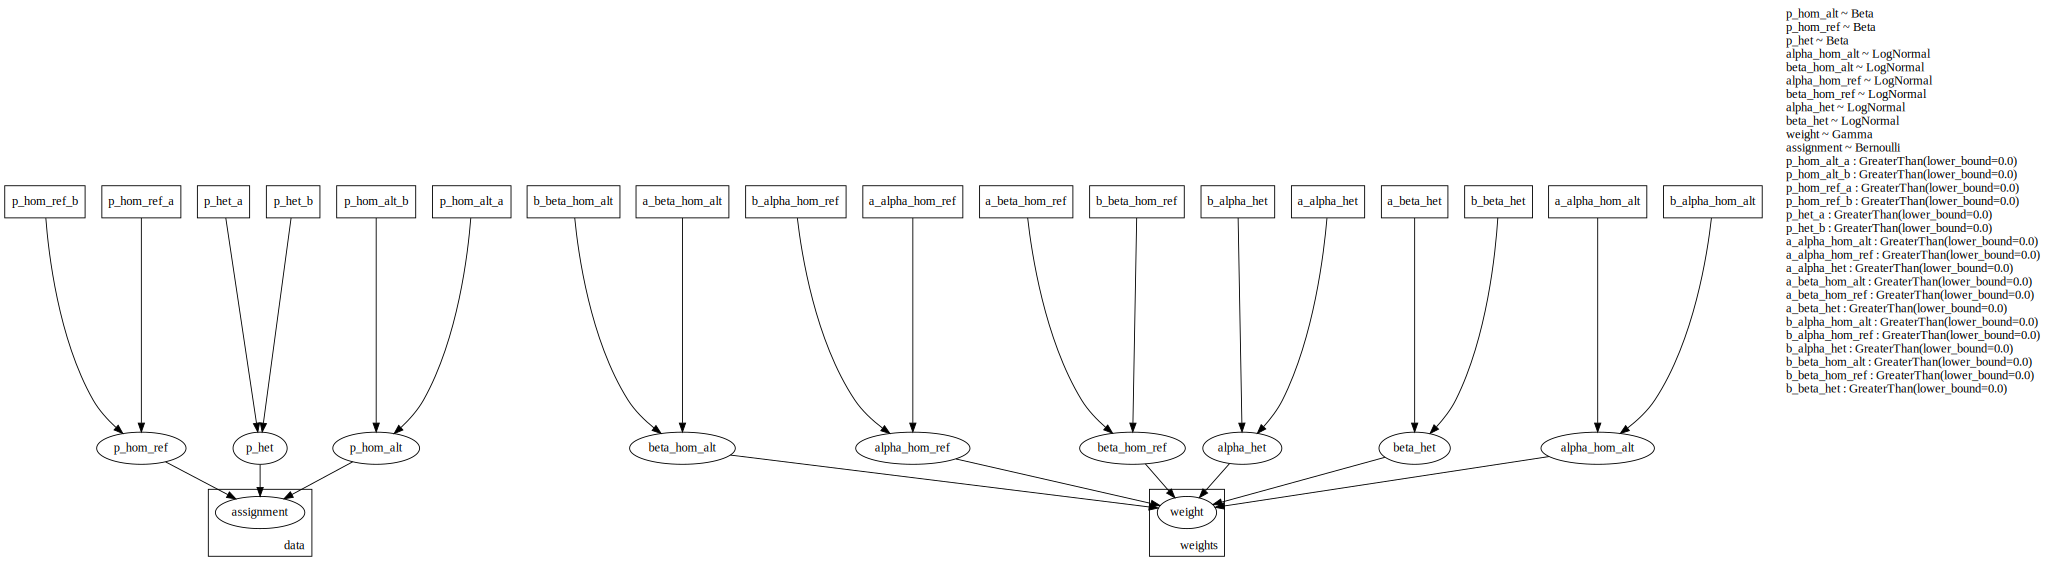

In [9]:
pyro.render_model(guide, model_args = (*train_x, train_y), render_params=True,render_distributions=True)

In [23]:
# Plotting histogram of predicttions vs true counts
def plot_hist(x, ground_truth, model, guide, title, log=False, savefig=None, nbins='auto', binwidth=None, xlim_right=None):
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1)
    svi_samples = predictive(*x, expression=None)
    svi_obs = svi_samples["obs"].detach().cpu().numpy()[0]#.mean(axis=1)
    ground_truth = ground_truth.detach().numpy()

    genotypes = ['Homozygous alternative', 'Homozygous reference', 'Heterozygous']
    fig, ax = plt.subplots(3, 1)
    fig.set_size_inches(6, 8)
    if log:
        fig.suptitle(f'{title}, log-scale', fontsize=16)
    else:
        fig.suptitle(title, fontsize=16)

    max_values = []
    for i in range(3):
        mask = (x[i] == 1).detach().numpy()
        if xlim_right is None:
            result = pd.DataFrame({'Expression': np.concatenate([svi_obs[mask], ground_truth[mask]]),
                                   'Source': np.concatenate([np.repeat('prediction', np.sum(mask)), np.repeat('ground truth', np.sum(mask))])})
        else:
            mask = np.logical_and(mask, svi_obs <= xlim_right)
            result = pd.DataFrame({'Expression': np.concatenate([svi_obs[mask], ground_truth[mask]]),
                                   'Source': np.concatenate([np.repeat('prediction', np.sum(mask)), np.repeat('ground truth', np.sum(mask))])})
        sns.histplot(result, x='Expression', hue='Source', 
                     bins=nbins, binwidth=binwidth, 
                     ax=ax[i])
        max_values.append(np.max(result['Expression']))

        if log:
            ax[i].set_yscale('log')
            
        ax[i].set_title(genotypes[i])
        ax[i].set_xlim(left=0, right=xlim_right)
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig, dpi=300)

Train for all samples

In [ ]:
for snp in data.keys():
    train_x = data[snp][0]
    train_y = data[snp][1]
    val_x = data[snp][2]
    val_y = data[snp][3]
    
    pyro.clear_param_store()
    
    adam = pyro.optim.Adam({'lr': 1e-2})
    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model, guide, adam, elbo)

    losses = []
    losses_val = []
    for step in tqdm(range(1000)):  # Consider running for more steps.
        loss = svi.step(*train_x, train_y)
        losses_val.append(elbo.loss(model, guide, *val_x, val_y))
        losses.append(loss)

        if step % 100 == 0:
            logging.info("Elbo loss: {}".format(loss))

    plt.figure(figsize=(7, 3))
    plt.title(f'Loss: {snp}')
    plt.plot(losses, label='train')
    plt.plot(losses_val, label='validation')
    plt.xlabel("SVI step")ii
    plt.ylabel("ELBO loss")
    plt.legend()
    plt.savefig(f'figures/FINAL_Loss_{snp}.png', dpi=300)
    
    pyro.get_param_store().save(f'{snp}_parameters')
    
    
    plot_hist(train_x, train_y, model, guide, f'Training dataset', log=True, savefig=f'figures/FINAL_Training_dataset_{snp}.png')
    plot_hist(train_x, train_y, model, guide, f'Training dataset, interval [0, 10]', log=True, savefig=f'figures/FINAL_Training_dataset_{snp}_zoom0-10.png', binwidth = 0.5, xlim_right=10)

Plot results for training dataset (training dataset actual counts and predictions for training x)

rs10088428_CD4 NC_HMBOX1
rs12450225_CD4 NC_HOXB2


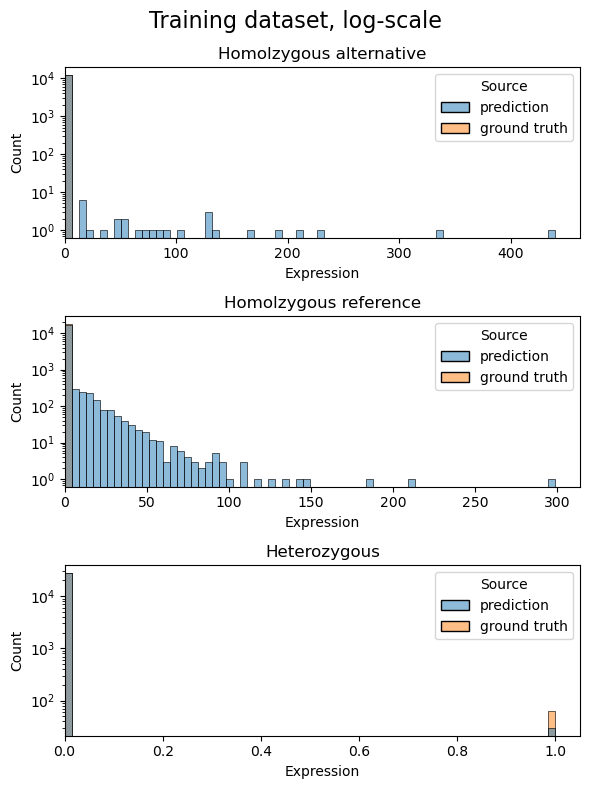

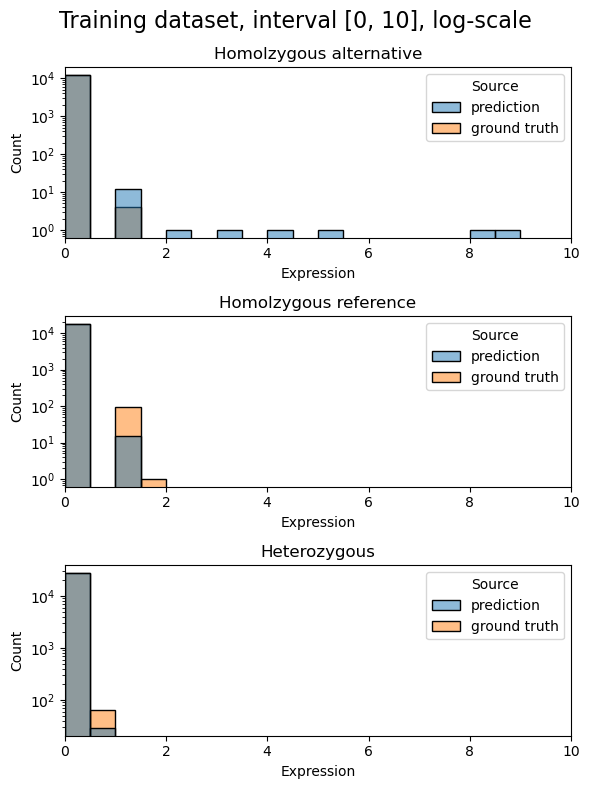

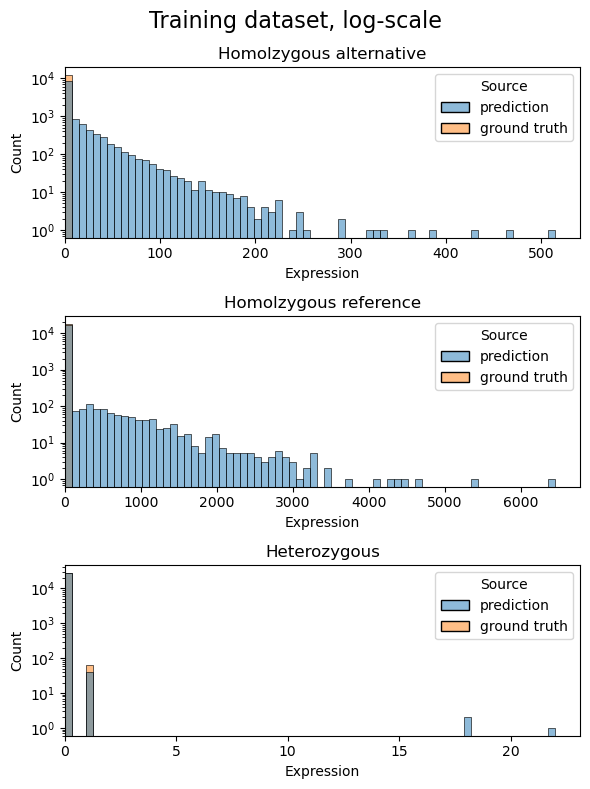

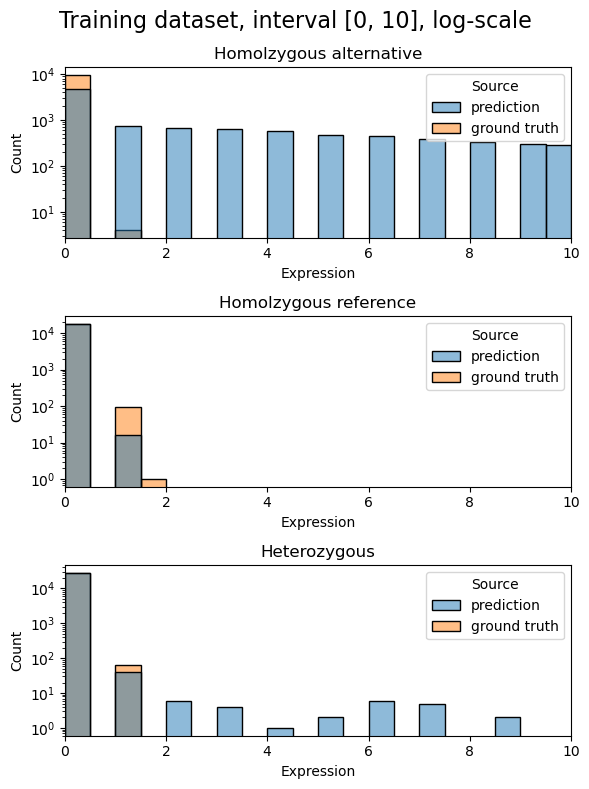

In [29]:
for snp in data.keys():
    pyro.clear_param_store()
    pyro.get_param_store().load(f'{snp}_parameters')
    plot_hist(train_x, train_y, model, guide, f'Training dataset', log=True, nbins=70, savefig=f'figures/FINAL_Training_dataset_{snp}.png')
    plot_hist(train_x, train_y, model, guide, f'Training dataset, interval [0, 10]', log=True, savefig=f'figures/FINAL_Training_dataset_{snp}_zoom0-10.png', binwidth = 0.5, xlim_right=10)

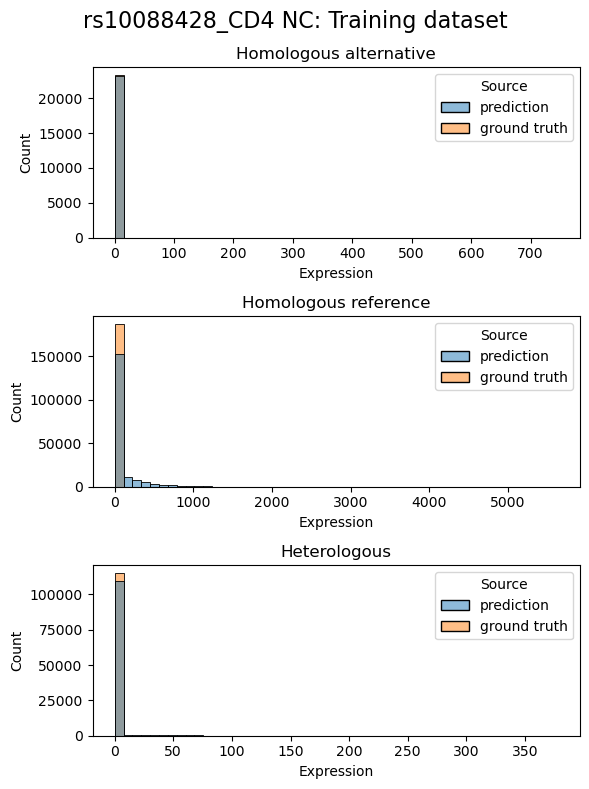

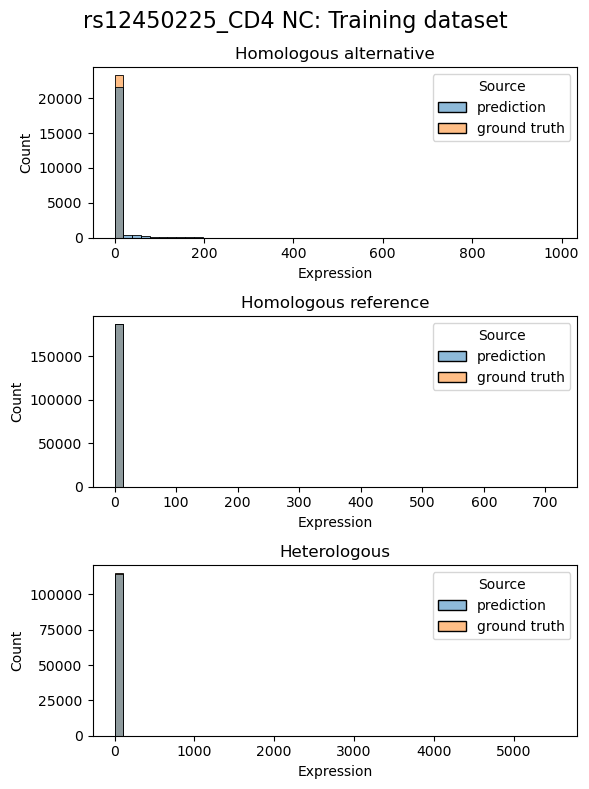

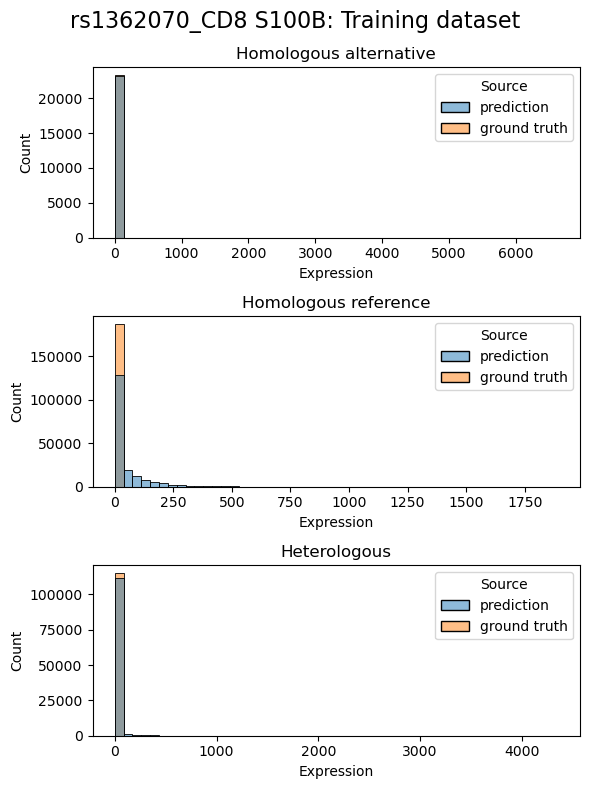

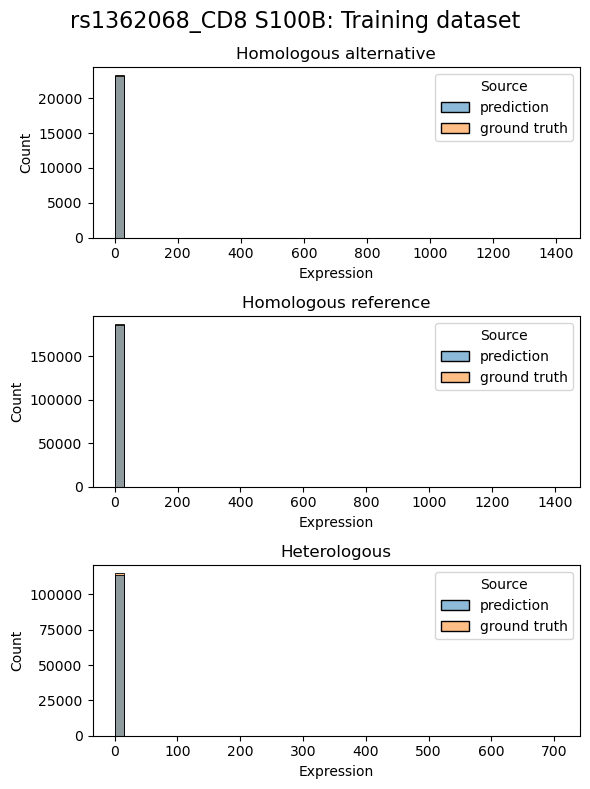

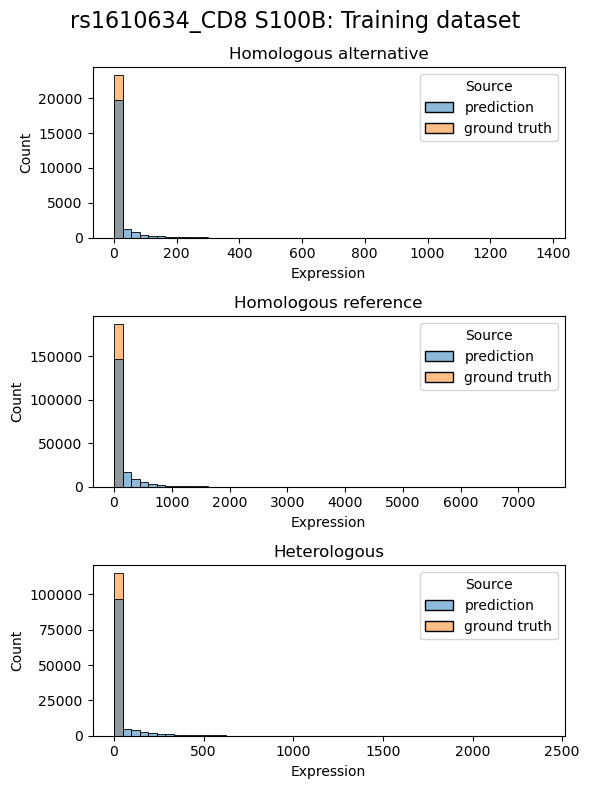

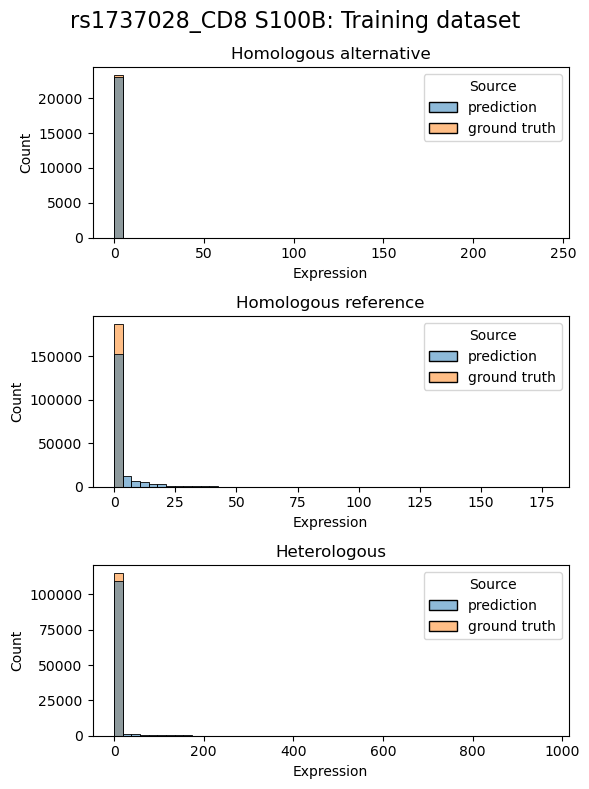

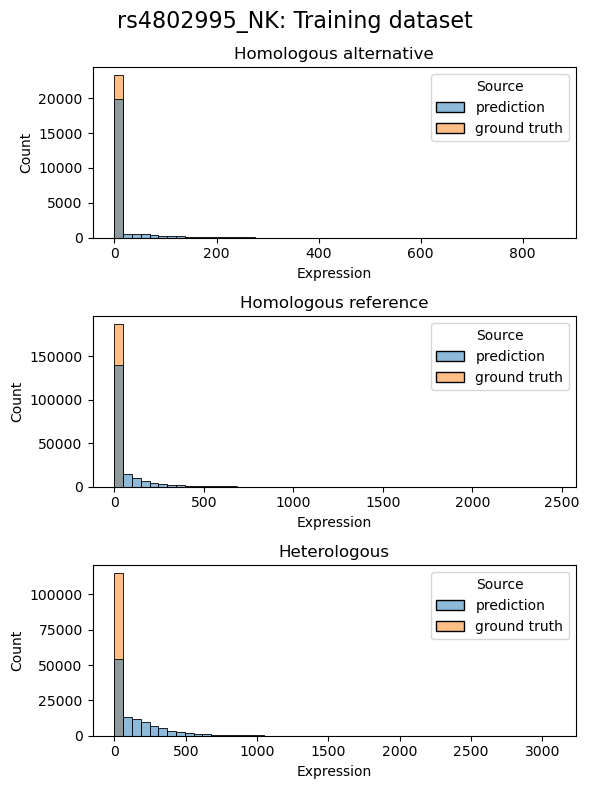

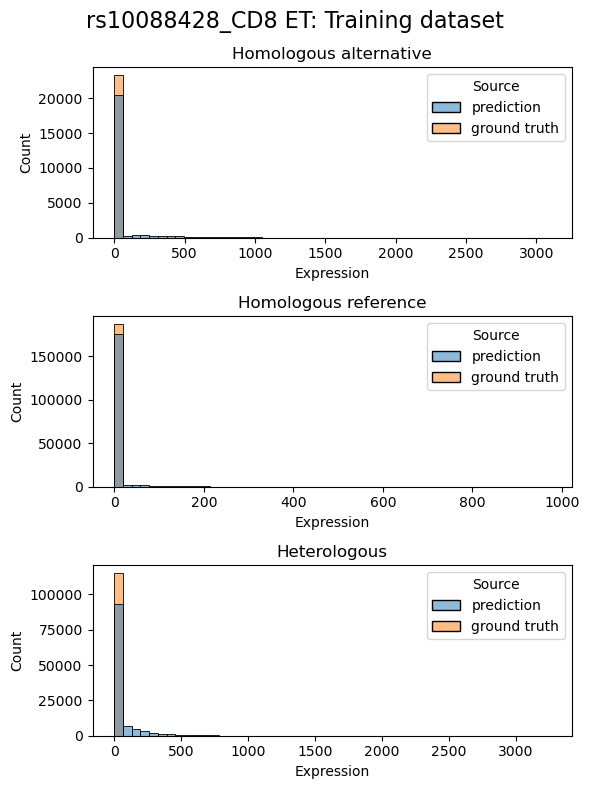

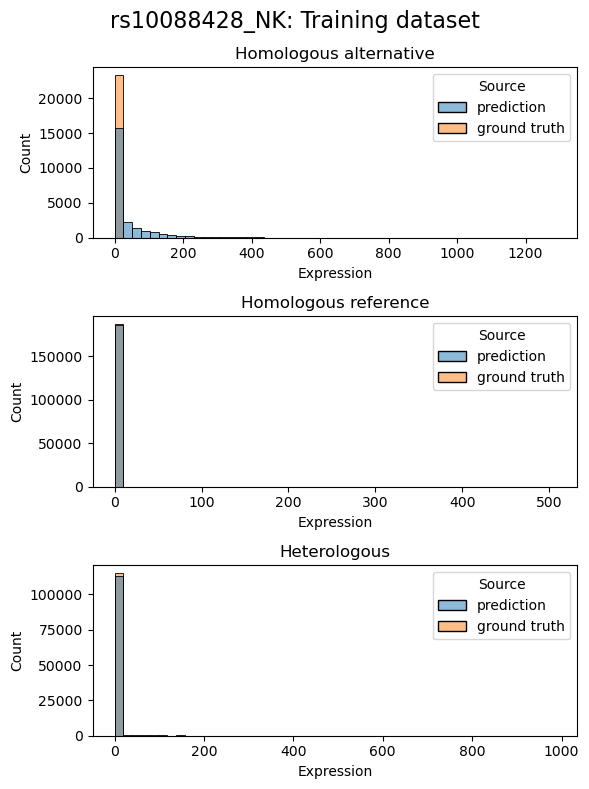

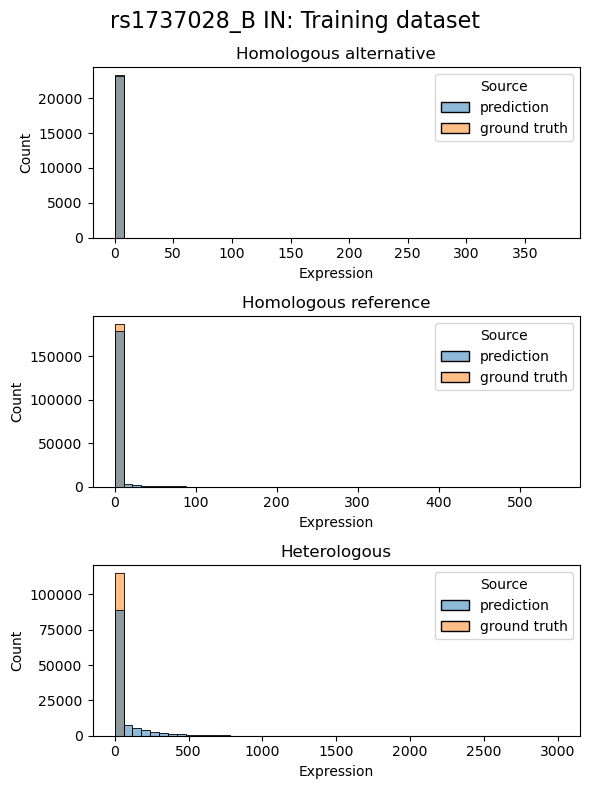

In [410]:
for snp in data.keys():
    pyro.clear_param_store()
    pyro.get_param_store().load(f'{snp}_parameters')
    plot_hist(train_x, train_y, model, guide, f'{snp}: Training dataset', log=False)

Get values of all parameters

In [403]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

p_hom_alt_a 1.0
p_hom_alt_b 1.0
p_hom_ref_a 1.0
p_hom_ref_b 1.0
p_het_a 1.0
p_het_b 1.0
a_alpha_hom_alt 1.0
a_alpha_hom_ref 1.0
a_alpha_het 1.0
a_beta_hom_alt 1.0
a_beta_hom_ref 1.0
a_beta_het 1.0
b_alpha_hom_alt 1.0
b_alpha_hom_ref 1.0
b_alpha_het 1.0
b_beta_hom_alt 1.0
b_beta_hom_ref 1.0
b_beta_het 1.0


Print comparison of pi values for different parameters

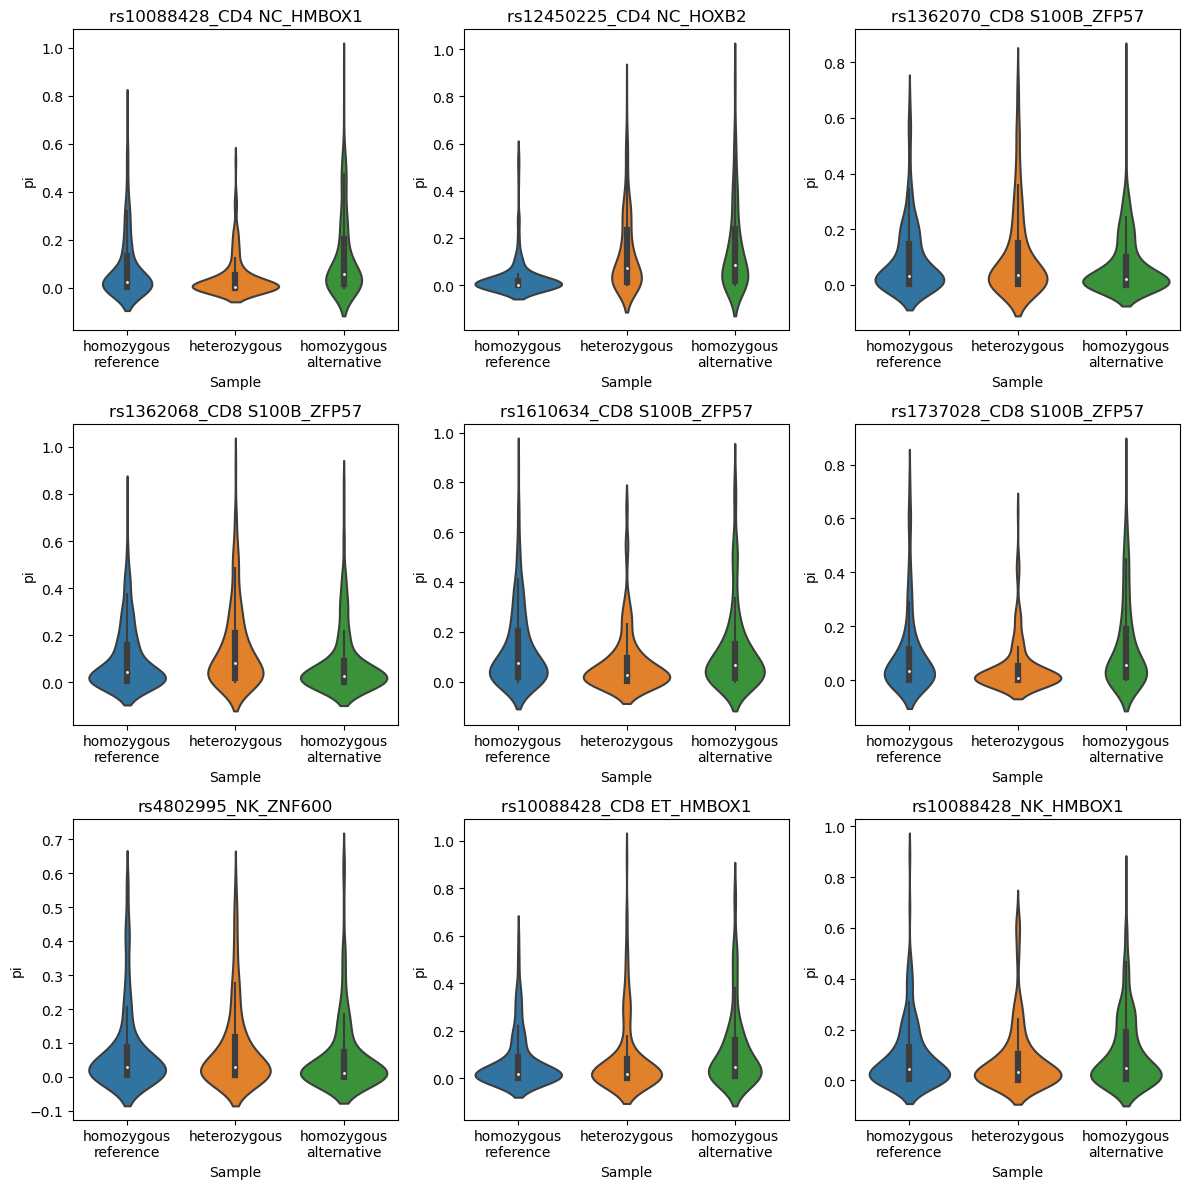

In [53]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(12, 12)
for i, snp in enumerate(data.keys()):
    pyro.clear_param_store()
    pyro.get_param_store().load(f'{snp}_parameters')
    p_hom_alt_dist = dist.Beta(pyro.param('p_hom_alt_a'), pyro.param('p_hom_alt_b'))
    p_hom_ref_dist = dist.Beta(pyro.param('p_hom_ref_a'), pyro.param('p_hom_ref_b'))
    p_het_dist = dist.Beta(pyro.param('p_het_a'), pyro.param('p_het_b'))
    p_hom_alt = p_hom_alt_dist.sample((200,))
    p_hom_ref = p_hom_ref_dist.sample((200,))
    p_het = p_het_dist.sample((200,))
    
    axis = ax.flatten()[i]
    axis.set_title(snp)
        
    df = pd.DataFrame({'homozygous\nreference': p_hom_ref,
                       'heterozygous': p_het,
                       'homozygous\nalternative': p_hom_alt})
    df_plot=df.melt(var_name='Sample', value_name='pi')

    sns.violinplot(df_plot, x='Sample', y='pi', ax=axis)
    if i >= 8:
        break
plt.tight_layout()
plt.savefig('figures/pi_values.png')